In [2]:
# PKG Tensorflow keras 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D,  LSTM, Flatten, MaxPooling1D
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks
from keras.models import save_model, load_model

# PKG Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelBinarizer

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import pickle
import joblib

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

%matplotlib inline

from keras.layers import BatchNormalization
from keras.layers import Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.layers as layers
from keras import regularizers
import keras.models as models
from tensorflow.keras.utils import plot_model
import pydot 
import graphviz 

In [3]:
#import PIL 
#import os 

#cwd = os.getcwd()
#files = os.listdir('./images')

#print('files in %r: %s' % (cwd, files))

In [4]:
with open('data/data_deep.pkl', 'rb') as f:
    my_unpickle = pickle.Unpickler(f)
    data = my_unpickle.load()

In [5]:
data.shape

(301090, 17)

In [6]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,target
67,117E,hydrolase,X-RAY DIFFRACTION,Protein,6.349139,0.765468,11.085264,vapor diffusion hanging drop,293.0,0.996949,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",acide,1998.0,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,hydrolase
68,117E,hydrolase,X-RAY DIFFRACTION,Protein,6.349139,0.765468,11.085264,vapor diffusion hanging drop,293.0,0.996949,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",acide,1998.0,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,hydrolase
74,11AS,ligase,X-RAY DIFFRACTION,Protein,6.492240,0.916291,11.205462,vapor diffusion hanging drop,293.0,0.832909,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,basique,1998.0,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,ligase
75,11AS,ligase,X-RAY DIFFRACTION,Protein,6.492240,0.916291,11.205462,vapor diffusion hanging drop,293.0,0.832909,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,basique,1998.0,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,ligase
76,11BA,hydrolase,X-RAY DIFFRACTION,Protein,5.513429,0.722706,10.264662,vapor diffusion hanging drop,293.0,0.908259,50.36,pH 4.8,acide,1998.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,hydrolase


In [4]:
#data.macromoleculeType.value_counts()

In [7]:
# check missing values 

pd.DataFrame({'Total': data.isna().sum(),
             'Percent': data.isna().sum()/data.shape[0],
             'Types': data.dtypes})

,Total,Percent,Types
structureId,0,0.0,object
classification,0,0.0,object
experimentalTechnique,0,0.0,object
macromoleculeType,0,0.0,object
residueCount,0,0.0,float64
resolution,0,0.0,float64
structureMolecularWeight,0,0.0,float64
crystallizationMethod,0,0.0,object
crystallizationTempK,0,0.0,float64
densityMatthews,0,0.0,float64


In [8]:
# selecting features for deep 

df = data.copy()

df = data.loc[:, ['sequence', 'target']]

In [11]:
sequences = df.sequence.values
length = [len(s) for s in sequences]

In [13]:
np.mean(length)

268.76745491381314

In [14]:
df.shape

(301090, 2)

In [15]:
data.isnull().sum()

structureId                 0
classification              0
experimentalTechnique       0
macromoleculeType           0
residueCount                0
resolution                  0
structureMolecularWeight    0
crystallizationMethod       0
crystallizationTempK        0
densityMatthews             0
densityPercentSol           0
pdbxDetails                 0
phValue                     0
publicationYear             0
chainId                     0
sequence                    0
target                      0
dtype: int64

In [16]:
X = df['sequence']
Y = df['target']

In [17]:
# Transformation des labels en one hot 
lb = LabelBinarizer()
Y_encoded = lb.fit_transform(Y)

In [18]:
# save lb 

filename = 'data/label_binarizer.sav'
pickle.dump(lb, open(filename, 'wb'))

In [19]:
maxlen = 268 # dim_seq mean

#créer un tokenizer et l'entrainer 
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)
#representation de la variable explicative en sequence des nombres 
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=maxlen)

In [20]:
# save tokenizer

filename = 'data/tokenizer_deep.sav'
pickle.dump(tokenizer, open(filename, 'wb'))

In [21]:
# nombre des caractères distincts stockés dans le max_id
max_id = len(tokenizer.word_index)
max_id

25

In [22]:
# split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240872, 268), (60218, 268), (240872, 17), (60218, 17))

#### CNN1 With Batch Normalization 

In [29]:
embedding_dim = 8
numb_classes = 17

model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, numb_classes, input_length=268))
model.add(Conv1D(filters=128, kernel_size=12, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=6, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(1056))
model.add(Activation('relu'))

model.add(Dense(17, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy'])

#es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 268, 17)           442       
                                                                 
 conv1d_3 (Conv1D)           (None, 268, 128)          26240     
                                                                 
 activation_4 (Activation)   (None, 268, 128)          0         
                                                                 
 batch_normalization_3 (Batc  (None, 268, 128)         512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 134, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 134, 64)          

In [30]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

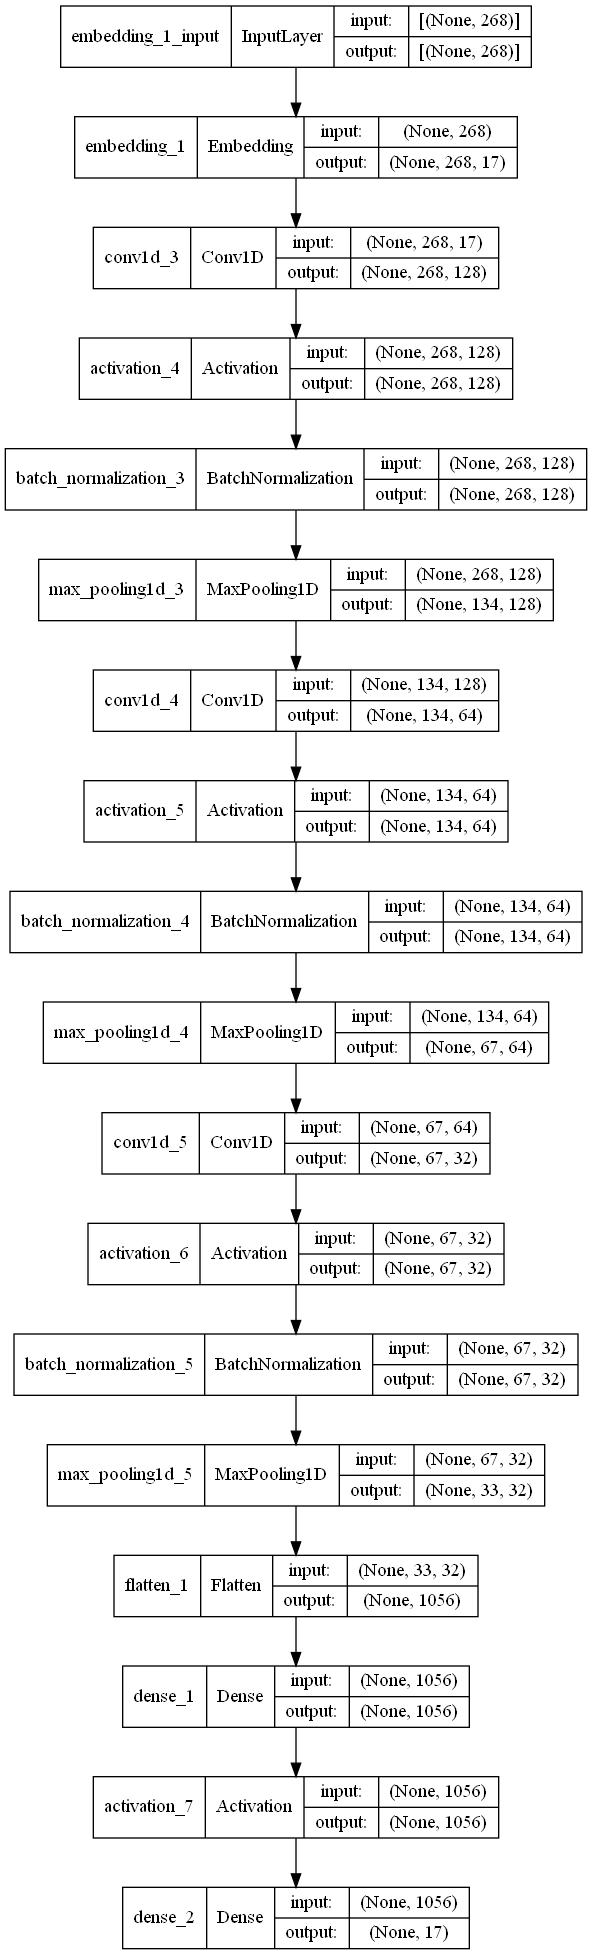

In [31]:
plot_model(model, 'model.png' ,show_shapes=True)

In [33]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=250)

Epoch 1/10
964/964 [==============================] - 1007s 1s/step - loss: 0.8317 - accuracy: 0.7522 - val_loss: 0.6313 - val_accuracy: 0.8110
Epoch 2/10
964/964 [==============================] - 996s 1s/step - loss: 0.4566 - accuracy: 0.8607 - val_loss: 0.5161 - val_accuracy: 0.8508
Epoch 3/10
964/964 [==============================] - 995s 1s/step - loss: 0.3531 - accuracy: 0.8889 - val_loss: 0.4571 - val_accuracy: 0.8676
Epoch 4/10
964/964 [==============================] - 1016s 1s/step - loss: 0.3036 - accuracy: 0.9032 - val_loss: 0.4397 - val_accuracy: 0.8742
Epoch 5/10
964/964 [==============================] - 1005s 1s/step - loss: 0.2755 - accuracy: 0.9114 - val_loss: 0.4182 - val_accuracy: 0.8816
Epoch 6/10
964/964 [==============================] - 1047s 1s/step - loss: 0.2586 - accuracy: 0.9150 - val_loss: 0.4299 - val_accuracy: 0.8778
Epoch 7/10
964/964 [==============================] - 1016s 1s/step - loss: 0.2439 - accuracy: 0.9184 - val_loss: 0.4154 - val_accuracy: 0

In [34]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train-acc = 0.926371682885516
test-acc = 0.8862300308877744


In [35]:
model.evaluate(X_train)

7528/7528 [==============================] - 298s 39ms/step - loss: 0.2126 - accuracy: 0.9264


[0.21264153718948364, 0.926371693611145]

In [36]:
model.evaluate(X_test)

1882/1882 [==============================] - 80s 42ms/step - loss: 0.4113 - accuracy: 0.88620s - loss: 0.4112 - accuracy: 0.


[0.4113108515739441, 0.8862300515174866]

In [23]:
#print('Predicted: %s (class=%d)' % (test_pred, np.argmax(test_pred)))

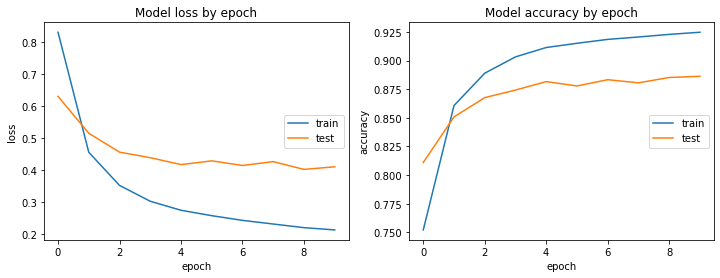

In [37]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [44]:
print(classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), target_names=lb.classes_))
#print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=0), np.argmax(test_pred, axis=1))))

                                      precision    recall  f1-score   support

                           hydrolase       0.91      0.93      0.92     38345
       hydrolase/hydrolase inhibitor       0.82      0.75      0.78     10815
                       immune system       0.96      0.98      0.97     12814
                           isomerase       0.97      0.97      0.97      5304
                              ligase       0.96      0.96      0.96      4113
                               lyase       0.98      0.98      0.98      9522
                      oxidoreductase       0.98      0.99      0.99     28044
                     protein binding       0.93      0.88      0.91      4083
                            ribosome       0.86      0.99      0.92     48634
                 ribosome/antibiotic       0.70      0.05      0.09      8249
                   signaling protein       0.92      0.91      0.91      5208
structural genomics/unknown function       0.98      0.94      

In [46]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                      precision    recall  f1-score   support

                           hydrolase       0.86      0.90      0.88      9488
       hydrolase/hydrolase inhibitor       0.79      0.73      0.76      2669
                       immune system       0.90      0.95      0.92      3175
                           isomerase       0.94      0.94      0.94      1309
                              ligase       0.91      0.86      0.88      1006
                               lyase       0.95      0.95      0.95      2349
                      oxidoreductase       0.95      0.97      0.96      7070
                     protein binding       0.78      0.71      0.74       989
                            ribosome       0.84      0.99      0.91     12069
                 ribosome/antibiotic       0.61      0.03      0.07      2160
                   signaling protein       0.83      0.74      0.78      1361
structural genomics/unknown function       0.89      0.71      

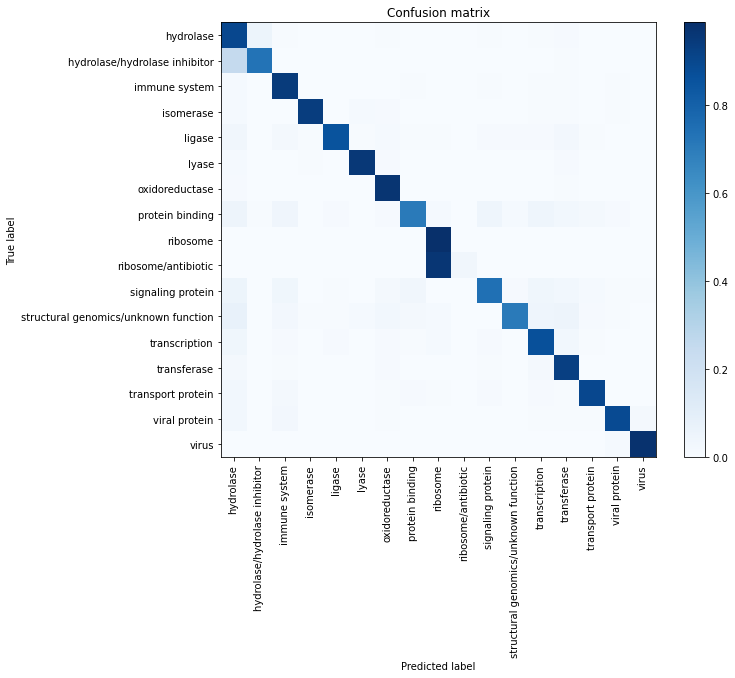

In [55]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Saving Model 

In [53]:
filename = 'data/model_deep_cnn1.pkl'
save_model(model, filename)

INFO:tensorflow:Assets written to: data/model_deep_cnn1.pkl\assets


#### LSTM 

In [59]:
model1 = Sequential()
model1.add(Embedding(len(tokenizer.word_index)+1, 17, input_length = 268))
model1.add(LSTM(25, return_sequences = True))
model1.add(Flatten())
#model1.add(Dense(6700,activation='sigmoid'))
model1.add(Dense(17,activation='softmax'))
model1.compile(loss = 'categorical_crossentropy',
               optimizer='adam',
               metrics = ['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', 
                                                 
                                                  restore_best_weights=True, 
                                                  patience=2)
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 268, 17)           442       
                                                                 
 lstm_1 (LSTM)               (None, 268, 25)           4300      
                                                                 
 flatten_3 (Flatten)         (None, 6700)              0         
                                                                 
 dense_5 (Dense)             (None, 17)                113917    
                                                                 
Total params: 118,659
Trainable params: 118,659
Non-trainable params: 0
_________________________________________________________________


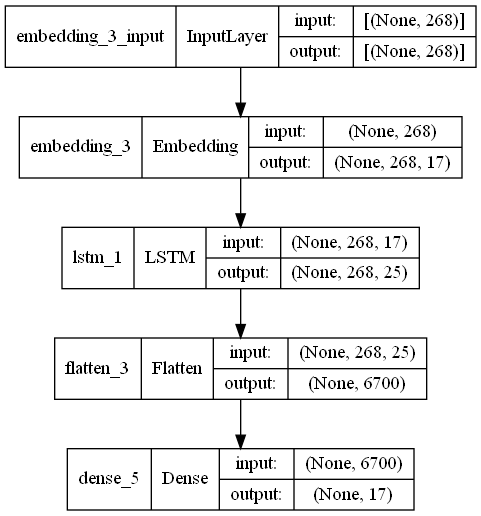

In [60]:
plot_model(model1, 'model.png' ,show_shapes=True)

In [61]:
history_lstm = model1.fit(X_train, y_train, 
                          epochs=10, 
                         callbacks=early_stopping)

Epoch 1/10
7528/7528 [==============================] - 897s 119ms/step - loss: 1.2828 - accuracy: 0.6061
Epoch 2/10
7528/7528 [==============================] - 885s 118ms/step - loss: 0.8730 - accuracy: 0.7385
Epoch 3/10
7528/7528 [==============================] - 891s 118ms/step - loss: 0.7149 - accuracy: 0.7848
Epoch 4/10
7528/7528 [==============================] - 923s 123ms/step - loss: 0.6255 - accuracy: 0.8106
Epoch 5/10
7528/7528 [==============================] - 905s 120ms/step - loss: 0.5675 - accuracy: 0.8266
Epoch 6/10
7528/7528 [==============================] - 891s 118ms/step - loss: 0.5278 - accuracy: 0.8382
Epoch 7/10
7528/7528 [==============================] - 897s 119ms/step - loss: 0.4965 - accuracy: 0.8465
Epoch 8/10
7528/7528 [==============================] - 914s 121ms/step - loss: 0.4718 - accuracy: 0.8536
Epoch 9/10
7528/7528 [==============================] - 911s 121ms/step - loss: 0.4521 - accuracy: 0.8581
Epoch 10/10
7528/7528 [=======================

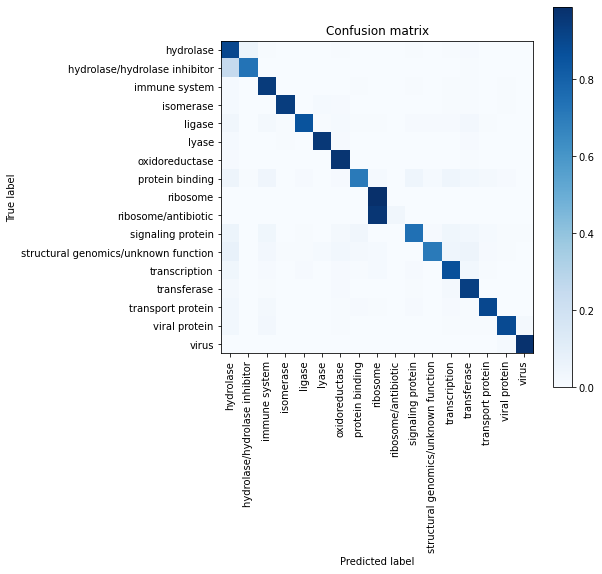

In [62]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [63]:
def plot_model_results(model):
    
    accuracy = history.history['accuracy']
    loss = history.history['loss']
    
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy LSTM')
    
    plt.ylabel('% accuracy')
    plt.xlabel('Epoch')
    #plt.ylim(0.1, 1.0)
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Model Loss LSTM')
    
    plt.ylabel('% loss')
    plt.xlabel('Epoch')
    #plt.ylim(0.1, 1.0)
    plt.legend()
    plt.show()

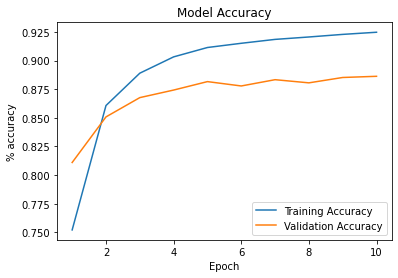

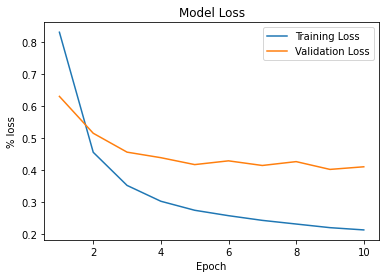

In [64]:
plot_model_results(model1)

In [67]:
train_pred = model1.predict(X_train)
test_pred = model1.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train-acc = 0.8822445116078249
test-acc = 0.840662260453685


In [70]:
train_pred_lstm= model1.predict(X_train)
test_pred_lstm = model1.predict(X_test)

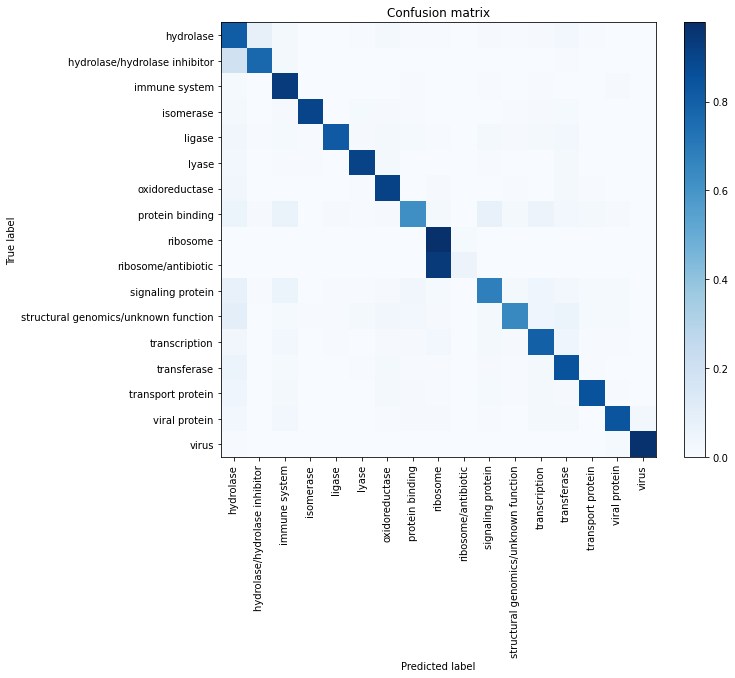

In [71]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred_lstm, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred_lstm, axis=1), target_names=lb.classes_))

In [73]:
filename = 'data/model_deep_lstm.pkl'
save_model(model1, filename)

INFO:tensorflow:Assets written to: data/model_deep_lstm.pkl\assets


INFO:tensorflow:Assets written to: data/model_deep_lstm.pkl\assets


### Interpretabilité 

#### . CNN1D

In [1]:
import shap 
shap.initjs()

In [ ]:
explainer = shap.KernelExplainer(model.predict, X_train.iloc[0, :], link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")